In [1]:
import os
import sys 
import glob 

import numpy as np
import pandas as pd
from tqdm import tqdm

import torch 
import torch.nn as nn 
import torch.utils.data as data
import torch.nn.functional as F
import torch.optim as optims
from torchvision import models,transforms


from pathlib import Path
from PIL import Image
from sklearn.metrics import confusion_matrix,accuracy_score
import matplotlib.pyplot as plt
import cv2

#from dataset import Dataset

/home/ksuga/fiveprime/.venv/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Dataset(data.Dataset):

    def __init__(self,data,transform=None):
        self.dataset=data # [path,label]のpdDF
        self.transform = transform
        
    def __len__(self):
        return self.dataset.shape[0]
    
    def __getitem__(self,idx):
        
        img = Image.open(self.dataset.iloc[idx]["path"])
        img = img.convert("RGB")
        #img = cv2.imread(self.dataset.iloc[idx]["path"])
        img = self.transform(img)

        return img,self.dataset.iloc[idx]["label"]

In [3]:
class CNN(nn.Module):
    def __init__(self,num_classes):
        super(CNN,self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)
        )
        self.fc1 = nn.Linear(in_features= 28 * 28 * 64, out_features=128)
        self.classifier = nn.Linear(in_features=128,out_features=num_classes)
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        #print(x.size())
        x = self.fc1(x)
        x = self.classifier(x)
        return x

In [4]:
path_label = pd.read_csv("binary_label.csv",index_col=0)

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

all_dataset = Dataset(path_label,transform)

n_train = int(len(all_dataset)*0.8)
n_val = len(all_dataset)-n_train

train_dataset,val_dataset = data.random_split(all_dataset,[n_train,n_val])
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=8,shuffle=True,num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset,batch_size=4,shuffle=False,num_workers=2)
dataset_dict = {"train":train_dataset,"val":val_dataset}
dataloaders_dict = {"train":train_loader,"val":val_loader}


In [5]:
#model  = timm.create_model("resnet18d",pretrained=True,num_classes=2)
model = CNN(num_classes=2)
#model = model.to(device)
"""
from efficientnet_pytorch import EfficientNet

model_ft = EfficientNet.from_pretrained("efficientnet-b7")
num_ftrs = model_ft._fc.in_features #全結合層の名前は"_fc"となっています
model_ft._fc = nn.Linear(num_ftrs, 2)
model_ft.to(device)
"""
"""
model = models.vgg16(pretrained=True)
model.classifier[6] = nn.Linear(in_features=4096,out_features=2)
model = nn.DataParallel(model)
"""

'\nmodel = models.vgg16(pretrained=True)\nmodel.classifier[6] = nn.Linear(in_features=4096,out_features=2)\nmodel = nn.DataParallel(model)\n'

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [7]:
n_epoch= 7
train_loss = []
val_loss =[]

train_acc = []
val_acc = []

for epoch in range(n_epoch):
    
    for phase in ["train","val"]:
        if phase=="train":
            model.train()
        else:
            model.eval()
        
        running_loss = 0.0
        running_corrects = 0

        for inputs,labels in tqdm(dataloaders_dict[phase]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase=="train"):
                outputs = model(inputs)
                _,preds = torch.max(outputs,1)
                loss = criterion(outputs,labels)
                
                if phase=="train":
                    loss.backward()
                    optimizer.step()
            
            running_loss+=loss.item()*inputs.size(0)
            running_corrects +=torch.sum(preds==labels.data)
            
    
        epoch_loss =running_loss /len(dataloaders_dict[phase])
        epoch_acc = running_corrects.double() / len(dataset_dict[phase])
        
        if phase=="train":
            train_loss.append(epoch_loss)
            train_acc.append(epoch_acc)
        else:
            val_loss.append(epoch_loss)
            val_acc.append(epoch_acc)
            print(f"epoch:{epoch},phase:{phase} Loss:{epoch_loss}, acc:{epoch_acc}")


    


100%|██████████| 15/15 [00:01<00:00, 13.13it/s]


epoch:0,phase:val Loss:2.0166213115056357, acc:0.8


100%|██████████| 15/15 [00:01<00:00, 13.12it/s]


epoch:1,phase:val Loss:2.190684604644775, acc:0.8


100%|██████████| 15/15 [00:01<00:00, 13.29it/s]


epoch:2,phase:val Loss:2.295062613487244, acc:0.8


100%|██████████| 15/15 [00:01<00:00, 13.30it/s]


epoch:3,phase:val Loss:2.2323493401209515, acc:0.7833333333333333


100%|██████████| 15/15 [00:01<00:00, 13.28it/s]


epoch:4,phase:val Loss:2.255431564648946, acc:0.8


100%|██████████| 15/15 [00:01<00:00, 13.44it/s]


epoch:5,phase:val Loss:2.713891045252482, acc:0.75


100%|██████████| 15/15 [00:01<00:00, 12.54it/s]

epoch:6,phase:val Loss:3.23238299091657, acc:0.7833333333333333


Text(0, 0.5, 'Loss')

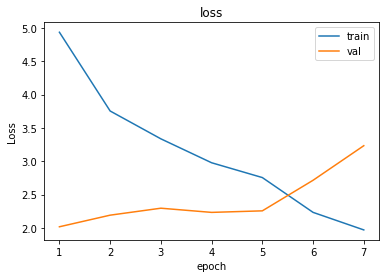

In [13]:
plt.plot(np.arange(1,n_epoch+1),train_loss,label="train")
plt.plot(np.arange(1,n_epoch+1),val_loss,label="val")
plt.legend()
plt.title("loss")
plt.xlabel("epoch")
plt.ylabel("Loss")

Text(0, 0.5, 'acc')

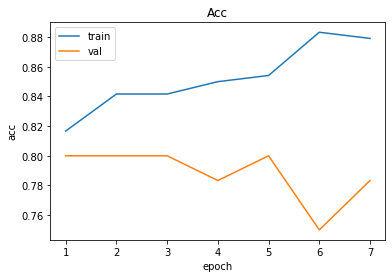

In [15]:
plt.plot(np.arange(1,n_epoch+1),train_acc,label="train")
plt.plot(np.arange(1,n_epoch+1),val_acc,label="val")
plt.legend()
plt.title("Acc")
plt.xlabel("epoch")
plt.ylabel("acc")